In [69]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
import json
import cv2
import numpy as np
from PIL import Image
import pycocotools.mask as maskUtils

from matting_api import Matting

sys.path.append('..')
import utils
import inference as infer
from datasets import COCOADataset, read_COCOA
from demo_utils import *

font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [42]:
# functions

def read_annot(fn, h, w):
    with open(fn, 'r') as f:
        ann = json.load(f)
    ret_modal, ret_bboxes, ret_category, ret_amodal = [], [], [], []
    for reg in ann['regions']:
        modal, bbox, category = read_COCOA(reg, h, w)
        ret_modal.append(modal)
        ret_bboxes.append(bbox)
        ret_category.append(category)
        amodal = maskUtils.decode(maskUtils.merge(
            maskUtils.frPyObjects([reg['segmentation']], h, w)))
        ret_amodal.append(amodal)
    return np.array(ret_modal), np.array(ret_category), np.array(ret_bboxes), np.array(ret_amodal)

def simple_inpaint(pcnetc, rgb, input_size, invisible_mask, dilate, bbox=None):
    h, w = rgb.shape[:2]
    if bbox is None:
        bbox = get_square_bbox(*rgb.shape[:2])
    rgb = cv2.resize(
        utils.crop_padding(rgb, bbox, pad_value=(0,0,0)), (input_size, input_size), interpolation=cv2.INTER_CUBIC)
    invisible_mask = infer.resize_mask(
        utils.crop_padding(invisible_mask, bbox, pad_value=(0,)), input_size, 'linear')
    rgb = pcnetc.img_transform(torch.from_numpy(
        rgb.astype(np.float32).transpose((2, 0, 1)) / 255.)).unsqueeze(0)
    if dilate > 0:
        invisible_mask = cv2.dilate(invisible_mask, np.ones((dilate,dilate),np.uint8), iterations=1)
    visible_mask = (1 - invisible_mask).astype(np.float32)[np.newaxis,np.newaxis,:,:]
    visible_mask = torch.from_numpy(visible_mask)
    modal_mask = visible_mask.cuda()
    rgb_erased = rgb * visible_mask.repeat(1,3,1,1)
    visible_mask4 = visible_mask.repeat(1, 4, 1, 1)
    output, _ = pcnetc.model.model(
        torch.cat([rgb_erased.cuda(), modal_mask], dim=1),
        visible_mask4.cuda())
    output_comp = visible_mask * rgb + (1 - visible_mask) * output.detach().cpu()
    result = torch.clamp(utils.unormalize(
        output_comp, pcnetc.args.data['data_mean'], pcnetc.args.data['data_std']) * 255, 0, 255)
    ret = result.numpy().astype(np.uint8).squeeze().transpose((1,2,0))
    ret = recover_image_patch(ret, bbox, h, w, (255,255,255), interp='cubic')
    return ret

def bkg_inpaint(pcnetc, image, input_size, modal, ex_ind, dilate, bbox=None):
    modal_bkg = (sum([modal[e] for e in ex_ind]) == 0).astype(np.uint8)
    amodal_bkg = np.ones(image.shape[:2], dtype=np.uint8)
    need_recover = False
    if bbox is None:
        need_recover = True
        bbox = get_square_bbox(*image.shape[:2])
    rgb = cv2.resize(
        utils.crop_padding(image, bbox, pad_value=(0,0,0)), (input_size, input_size), interpolation=cv2.INTER_CUBIC)
    modal_patch = infer.resize_mask(
        utils.crop_padding(modal_bkg, bbox, pad_value=(0,)), input_size, 'linear')
    amodal_patch = infer.resize_mask(
        utils.crop_padding(amodal_bkg, bbox, pad_value=(0,)), input_size, 'linear')
    ret, rgb_erased, vsb_mask = pcnetc.inference(
        rgb, modal_patch, 1, amodal_patch, dilate=dilate, with_modal=True)
    if need_recover:
        ret = recover_image_patch(ret, bbox, image.shape[0], image.shape[1], (255,255,255), interp='cubic')
        vsb_mask = infer.recover_mask(vsb_mask, bbox, image.shape[0], image.shape[1], 'linear')
    return ret, vsb_mask

def content_completion(pcnetc, image, input_size, modal, bboxes, amodal_patches_pred, category, idx, dilate, debug=False):
    rgb = cv2.resize(
        utils.crop_padding(image, bboxes[idx], pad_value=(0,0,0)),
        (input_size, input_size), interpolation=cv2.INTER_CUBIC)
    modal_patch = infer.resize_mask(
       utils.crop_padding(modal[idx], bboxes[idx], pad_value=(0,)), input_size, 'linear')
    amodal_patch = infer.resize_mask(
        amodal_patches_pred[idx], input_size, 'linear')
    ret, rgb_erased, vsb_mask = pcnetc.inference(
        rgb, modal_patch, category[idx].item(), amodal_patch, dilate=dilate, with_modal=True)
    ret = recover_image_patch(ret, bboxes[idx], image.shape[0], image.shape[1], (255,255,255))
    vsb_mask = infer.recover_mask(vsb_mask, bbox, image.shape[0], image.shape[1], 'linear')
    return ret, vsb_mask

In [4]:
phase = 'val'
root_dict = {'train': "../data/COCOA/train2014", 'val': "../data/COCOA/val2014"}

img_root = root_dict[phase]
annot_path = "../data/COCOA/annotations/COCO_amodal_{}2014.json".format(phase)

data_reader = COCOADataset(annot_path)

In [5]:
# PCNet-M
exp = '../experiments/COCOA/pcnet_m'

config_file = exp + '/config.yaml'
load_model = '../released/COCOA_pcnet_m.pth.tar'

pcnetm = DemoPCNetM(config_file, load_model)

/home/xhzhan/proj/deocclusion/demos/demo_utils.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


=> loading checkpoint '../released/COCOA_pcnet_m.pth.tar'


In [6]:
# PCNet-C
exp = '../experiments/COCOA/pcnet_c'

config_file = exp + '/config.yaml'
load_model = '../released/COCOA_pcnet_c.pth.tar'

pcnetc = DemoPCNetC(config_file, load_model)

/home/xhzhan/proj/deocclusion/demos/demo_utils.py:51: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


=> loading checkpoint '../released/COCOA_pcnet_c.pth.tar'


In [7]:
# Matting
# Please download the pretrained model from: https://github.com/Yaoyi-Li/GCA-Matting/blob/master/README.md
matting_model = Matting(
    'GCAMatting/config/gca-dist-all-data.toml',
    'GCAMatting/checkpoints/gca-dist-all-data/gca-dist-all-data.pth')

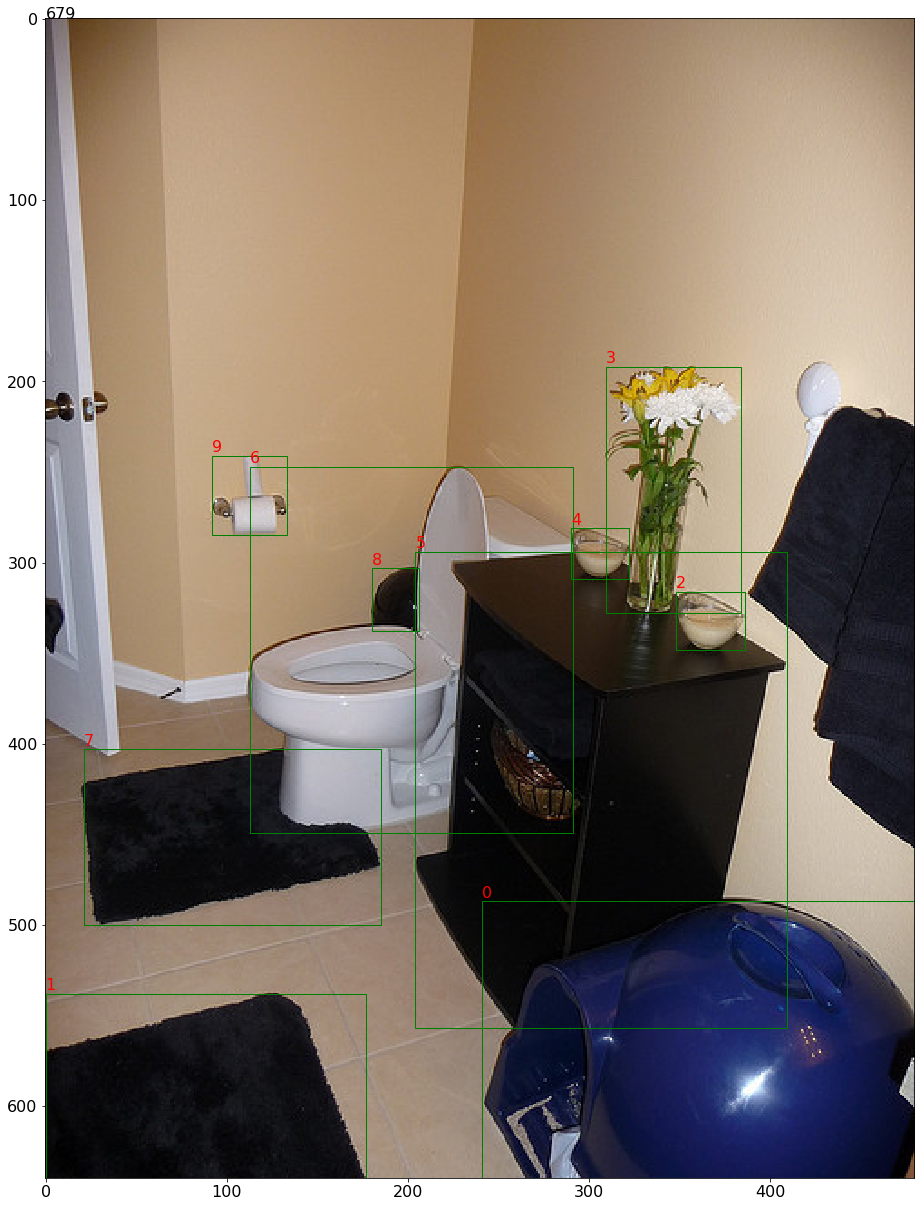

In [66]:
img_idx = 679 #
image_fn = 'demo_data/COCOA/{}.jpg'.format(img_idx)
annot_fn = 'demo_data/COCOA/{}.json'.format(img_idx)
img = Image.open(image_fn)
image = np.array(img)
height, width = img.height, img.width

modal, category, ori_bboxes, amodal_gt = read_annot(annot_fn, height, width)

plt.figure(figsize=(16, 16./width*height))
plt.imshow(img)
plt.text(0, 0, str(img_idx))
ax = plt.gca()
for i, bbox in enumerate(ori_bboxes):
    rect = patches.Rectangle(bbox[:2], bbox[2], bbox[3], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1]-2, str(i), color='r')
plt.show()

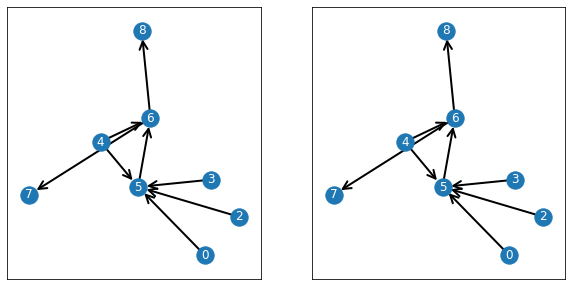

left: predicted ordering graph, right: ground truth ordering graph. Accuracy: 100.00%


In [67]:
# infer ordering
# ind=range(10)
ind = None
gt_order_matrix = infer.infer_gt_order(modal, amodal_gt)
bboxes = expand_bbox(ori_bboxes, enlarge_ratio=3., single_ratio=1.5)
order_matrix = infer.infer_order(
    pcnetm.model, image, modal, category, bboxes,
    use_rgb=pcnetm.use_rgb, th=0.1, dilate_kernel=0,
    input_size=256, min_input_size=16, interp='nearest', debug_info=False)
allpair_true, allpair, occpair_true, occpair, show_err = infer.eval_order(order_matrix, gt_order_matrix)
acc_occpair = occpair_true / occpair
plt.figure(figsize=(10,5))
plt.subplot(121)
pos = draw_graph(order_matrix, ind=ind)
plt.subplot(122)
draw_graph(gt_order_matrix, ind=ind, pos=pos)
plt.show()
print('left: predicted ordering graph, right: ground truth ordering graph. Accuracy: {:.2f}%'.format(acc_occpair * 100))

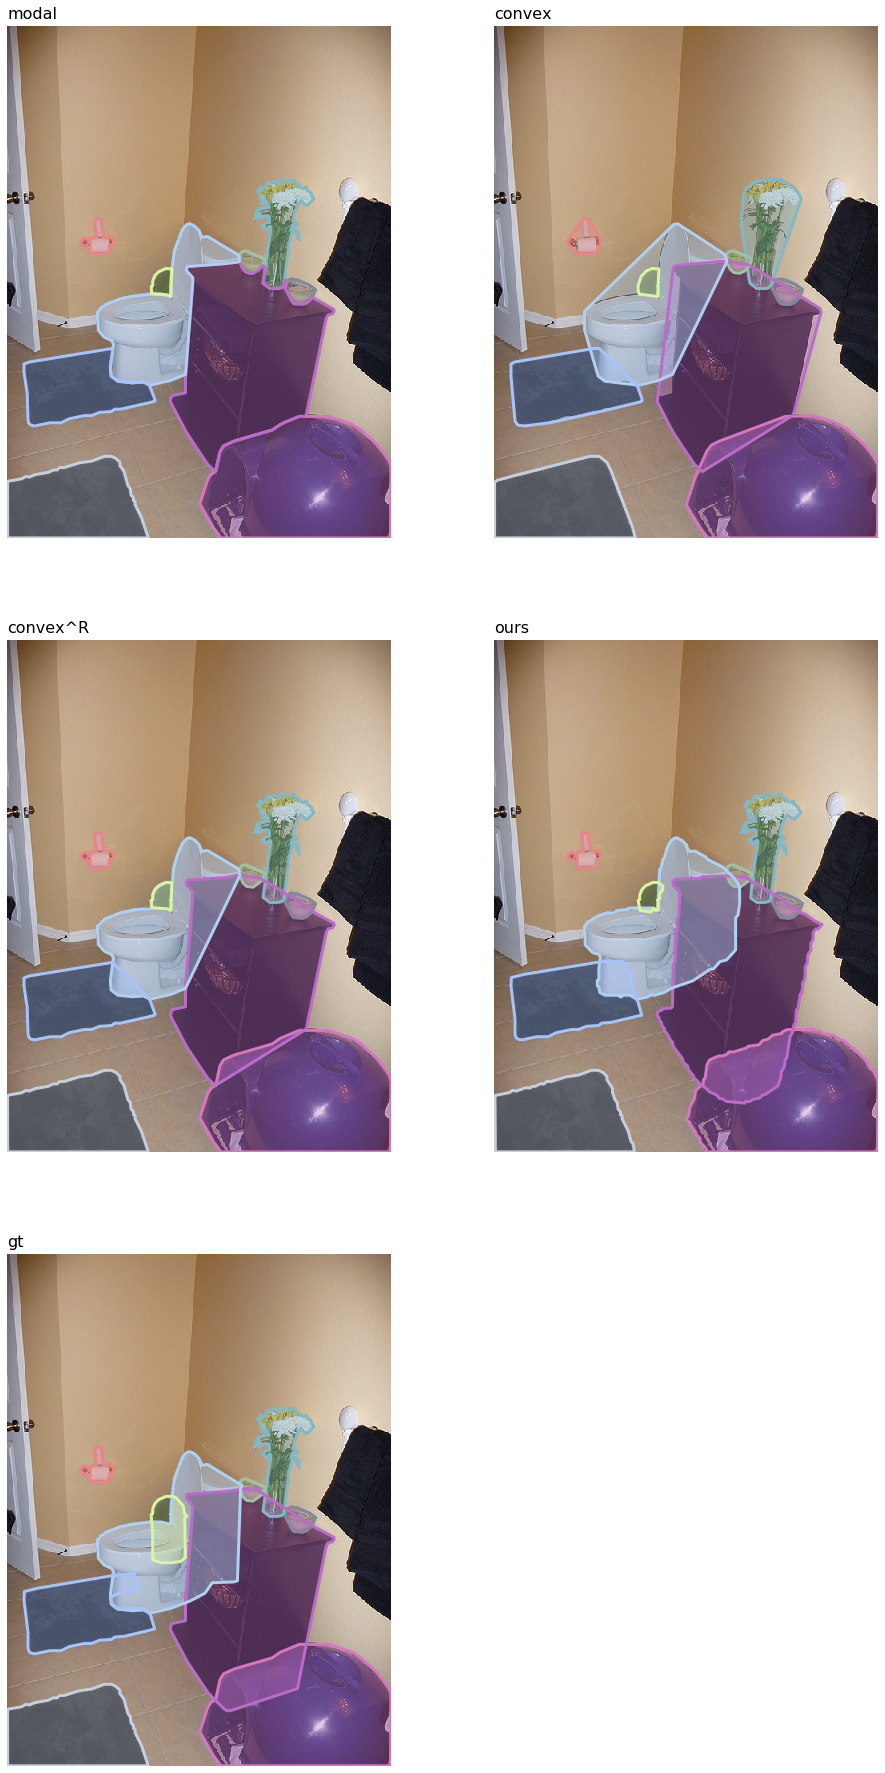

In [68]:
# amodal completion

# convex hull
order_matrix_cvx = infer.infer_order_hull(modal)
amodal_pred_cvx = np.array(infer.infer_amodal_hull(modal, bboxes, None, order_grounded=False))
amodal_pred_cvxr = np.array(infer.infer_amodal_hull(modal, bboxes, order_matrix_cvx, order_grounded=True))

# ours
amodal_patches_pred = infer.infer_amodal(
    pcnetm.model, image, modal, category, bboxes, order_matrix,
    use_rgb=pcnetm.use_rgb, th=0.5, dilate_kernel=0,
    input_size=256, min_input_size=16, interp='linear', debug_info=False)
amodal_pred_ours = infer.patch_to_fullimage(
    amodal_patches_pred, bboxes, image.shape[0], image.shape[1], interp='linear')

# show amodal
exclude = []
rows = 3
cols = 2
bbox_show = [0, 0, 500, height]
bbox_show = None

selidx = np.array([i for i in np.arange(modal.shape[0]) if i not in exclude])
image_show = image[bbox_show[1]:bbox_show[3], bbox_show[0]:bbox_show[2], :] \
    if bbox_show is not None else image.copy()

if bbox_show is not None:
    plt.figure(figsize=(16, 16./(bbox_show[2]-bbox_show[0])*(bbox_show[3]-bbox_show[1]) * 3 / 2))
else:
    plt.figure(figsize=(16, 16./width*height * rows / cols))
    
toshow = [modal, amodal_pred_cvx, amodal_pred_cvxr, amodal_pred_ours, amodal_gt]
title = ['modal', 'convex', 'convex^R', 'ours', 'gt']
colors = [(np.random.random((1, 3)) * 0.6 + 0.4).tolist()[0] for i in range(len(selidx))]
for i in range(len(toshow)):
    plt.subplot(rows, cols, i + 1)
    ax = plt.gca()
    plt.imshow(image_show)
    plt.axis('off')
    plt.text(0, -10, title[i])
    pface, pedge = polygon_drawing(toshow[i], selidx, colors, bbox_show, thickness=3)
    ax.add_collection(pface)
    ax.add_collection(pedge)
# plt.savefig('outputs/amodal_display/cocoa_{}.jpg'.format(img_idx), dpi=72)
plt.show()

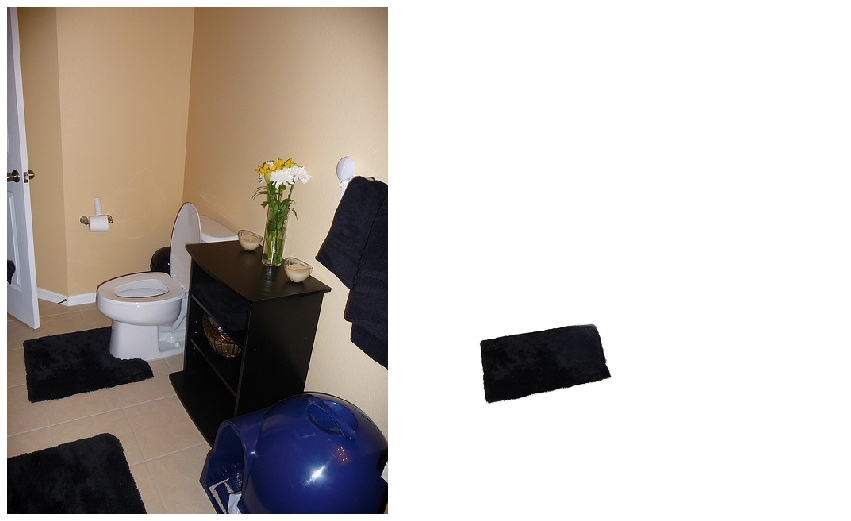

In [70]:
# content completion

show_idx = 7 # set to -1 to show the background

fg_idx = list(range(modal.shape[0]))
input_size = 256
input_size_bkg = 384
fg_dilate = int(float(input_size) / 256 * 5)
bg_dilate = int(float(input_size_bkg) / 256 * 3)

# for objects
rgb_decomps = []
mask_decomps = []
compose = lambda image, alpha: np.concatenate([image, alpha[:,:,np.newaxis]], axis=2)
for i in fg_idx:
    ret, vsb_mask = content_completion(pcnetc, image, input_size, modal, bboxes, amodal_patches_pred, category, i, fg_dilate, False)
    trimap = gettrimap(amodal_pred_ours[i], 3)
    alpha = matting_model.inference(ret, trimap)
    ret = compose(ret, alpha)
    rgb_decomps.append(ret)

# background inpainting
bkg, vsb_mask = bkg_inpaint(pcnetc, image, input_size_bkg, modal, fg_idx, bg_dilate)
for c in range(3):
    bkg[:,:,c][vsb_mask == 1] = image[:,:,c][vsb_mask == 1]

# show
plt.figure(figsize=(15, 30./img.width*img.height))
ax = plt.subplot(121)
plt.imshow(image)
plt.axis('off')
plt.subplot(122)
if show_idx == -1:
    plt.imshow(bkg)
else:
    this_obj = rgb_decomps[fg_idx.index(show_idx)]
    plt.imshow(this_obj)
plt.axis('off')
plt.show()

# save
if False:
    sort_ind = topological_sort(order_matrix)
    if not os.path.isdir('outputs/decomposition/image_{:04d}'.format(img_idx)):
        os.makedirs('outputs/decomposition/image_{:04d}'.format(img_idx))
    cv2.imwrite('outputs/decomposition/image_{:04d}.png'.format(img_idx), image[:,:,::-1])
    for i in sort_ind:
        obj = rgb_decomps[i]
        rgb = obj[:,:,:3]
        alpha = obj[:,:,3:]
        cv2.imwrite('outputs/decomposition/image_{:04d}/obj_{:03d}.png'.format(
            img_idx, i), np.concatenate([rgb[:,:,::-1], alpha], axis=2))
    cv2.imwrite('outputs/decomposition/image_{:04d}/bkg.png'.format(img_idx), bkg[:,:,::-1])